# Reducing Bias in Machine Learning Models - EDA

#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 1: Preliminary EDA](#eda)
    - 1.1: [Housekeeping](#housekeeping)
    - 1.2: [Disposition vs Demographic](#demo)
    - 1.3: [Disposition vs Triage Categorical Variables](#tcat)
    - 1.4: [Disposition vs Triage Numerical Variables](#tnum)
    - 1.5: [Disposition vs Hospital Usage](#huse)
    - 1.6: [Disposition vs Chief Complaint](#cc)
    - 1.7: [Disposition vs Prior Medical History](#pmh)
    - 1.8: [Disposition vs Medications](#meds) 
    - 1.9: [Disposition vs Median Glucose Reading](#glu)
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be uncovering the early relationships that exist between different columns and their affect on hospital admittance rate for diabetic patients.

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits in the original data set. After cleaning, there are now 476531 patient files being analyzed and 509 features. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)

---
### <a id = 'eda'></a> Part 1: Preliminary EDA

The goal of this Preliminary EDA is to understand the data and the relationship that exists between the features and the target variable (rate of admission). We will first look at the distribution of the various unique occurrences when compared to the whole data set within their respective columns. Then we will look at the admission rates of those unique occurrences compared to their column. Finally, I will perform a phi-coefficient test and their respective p-values to see the significance of the whole column when looking at it's affect on admission rate (the target)

For further EDA, I plan to dummy all of the categorical columns. I will be dropping the first column which would have the most occurrences as this would be my reference column. This way, I can begin to also do further investigation into how each unique occurrence in the dummy column affects disposition (the target). This way, we can begin to understand admission rates and likelihoods based on things like race, religion, etc. 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import itertools
from scipy.stats import chi2_contingency

Loading the clean csv file

In [179]:
health_data = pd.read_csv('Data/clean_health_data.csv')

In [180]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [181]:
health_data.head()

,demo_age,demo_gender,demo_race,demo_employstatus,demo_insurance_status,disposition,triage_cat_arrivalmonth,huse_previousdispo,pmh_2ndarymalig,pmh_abdomhernia,pmh_abdomnlpain,pmh_acqfootdef,pmh_acrenlfail,pmh_acutecvd,pmh_acutemi,pmh_acutphanm,pmh_adjustmentdisorders,pmh_adltrespfl,pmh_alcoholrelateddisorders,pmh_allergy,pmh_amniosdx,pmh_analrectal,pmh_anemia,pmh_aneurysm,pmh_anxietydisorders,pmh_appendicitis,pmh_artembolism,pmh_asppneumon,pmh_asthma,pmh_attentiondeficitconductdisruptivebeha,pmh_backproblem,pmh_biliarydx,pmh_birthtrauma,pmh_bladdercncr,pmh_blindness,pmh_bnignutneo,pmh_bonectcncr,pmh_bph,pmh_brainnscan,pmh_breastcancr,pmh_breastdx,pmh_brnchlngca,pmh_bronchitis,pmh_burns,pmh_cardiaarrst,pmh_cardiacanom,pmh_carditis,pmh_cataract,pmh_cervixcancr,pmh_chestpain,pmh_chfnonhp,pmh_chrkidneydisease,pmh_coaghemrdx,pmh_coloncancer,pmh_comabrndmg,pmh_complicdevi,pmh_complicproc,pmh_conduction,pmh_contraceptiv,pmh_copd,pmh_coronathero,pmh_crushinjury,pmh_cysticfibro,pmh_deliriumdementiaamnesticothercognitiv,pmh_developmentaldisorders,pmh_diabmelnoc,pmh_diabmelwcm,pmh_disordersusuallydiagnosedininfancych,pmh_diverticulos,pmh_dizziness,pmh_dminpreg,pmh_dysrhythmia,pmh_earlylabor,pmh_ecodesadverseeffectsofmedicalcare,pmh_ecodesadverseeffectsofmedicaldrugs,pmh_ecodescutpierce,pmh_ecodesfall,pmh_ecodesfirearm,pmh_ecodesmotorvehicletrafficmvt,pmh_ecodesotherspecifiedandclassifiable,pmh_ecodesotherspecifiednec,pmh_ecodesstruckbyagainst,pmh_ecodestransportnotmvt,pmh_ecodesunspecified,pmh_ectopicpreg,pmh_encephalitis,pmh_endometrios,pmh_epilepsycnv,pmh_esophcancer,pmh_esophgealdx,pmh_exameval,pmh_eyeinfectn,pmh_fatigue,pmh_femgenitca,pmh_feminfertil,pmh_fetaldistrs,pmh_fluidelcdx,pmh_fuo,pmh_fxarm,pmh_fxhip,pmh_fxleg,pmh_fxskullfac,pmh_gangrene,pmh_gasduoulcer,pmh_gastritis,pmh_gastroent,pmh_giconganom,pmh_gihemorrhag,pmh_giperitcan,pmh_glaucoma,pmh_goutotcrys,pmh_guconganom,pmh_hdnckcancr,pmh_headachemig,pmh_hemmorhoids,pmh_hemorrpreg,pmh_hepatitis,pmh_hivinfectn,pmh_hodgkinsds,pmh_hrtvalvedx,pmh_htn,pmh_htncomplicn,pmh_htninpreg,pmh_hyperlipidem,pmh_immunitydx,pmh_immunizscrn,pmh_impulsecontroldisordersnec,pmh_inducabortn,pmh_infectarth,pmh_influenza,pmh_infmalegen,pmh_intestinfct,pmh_intobstruct,pmh_intracrninj,pmh_jointinjury,pmh_kidnyrnlca,pmh_lateeffcvd,pmh_leukemias,pmh_liveborn,pmh_liveribdca,pmh_lowbirthwt,pmh_lungexternl,pmh_lymphenlarg,pmh_maintchemr,pmh_malgenitca,pmh_maligneopls,pmh_meningitis,pmh_menopausldx,pmh_menstrualdx,pmh_miscellaneousmentalhealthdisorders,pmh_mooddisorders,pmh_mouthdx,pmh_ms,pmh_multmyeloma,pmh_mycoses,pmh_nauseavomit,pmh_neoplsmunsp,pmh_nephritis,pmh_nervcongan,pmh_nonepithca,pmh_nonhodglym,pmh_nutritdefic,pmh_obrelatedperintrauma,pmh_opnwndextr,pmh_opnwndhead,pmh_osteoarthros,pmh_osteoporosis,pmh_otacqdefor,pmh_otaftercare,pmh_otbnignneo,pmh_otbonedx,pmh_otcirculdx,pmh_otcomplbir,pmh_otconganom,pmh_otconntiss,pmh_otdxbladdr,pmh_otdxkidney,pmh_otdxstomch,pmh_otendodsor,pmh_otfemalgen,pmh_othbactinf,pmh_othcnsinfx,pmh_othematldx,pmh_othercvd,pmh_othereardx,pmh_otheredcns,pmh_othereyedx,pmh_othergidx,pmh_othergudx,pmh_otherinjury,pmh_otherpregnancyanddeliveryincludingnormal,pmh_otherscreen,pmh_othfracture,pmh_othheartdx,pmh_othinfectns,pmh_othliverdx,pmh_othlowresp,pmh_othmalegen,pmh_othnervdx,pmh_othskindx,pmh_othveindx,pmh_otinflskin,pmh_otitismedia,pmh_otjointdx,pmh_otnutritdx,pmh_otperintdx,pmh_otpregcomp,pmh_otprimryca,pmh_otrespirca,pmh_otupprresp,pmh_otuprspin,pmh_ovariancyst,pmh_ovarycancer,pmh_pancreascan,pmh_pancreasdx,pmh_paralysis,pmh_parkinsons,pmh_pathologfx,pmh_pelvicobstr,pmh_peripathero,pmh_peritonitis,pmh_personalitydisorders,pmh_phlebitis,pmh_pid,pmh_pleurisy,pmh_pneumonia,pmh_poisnnonmed,pmh_poisnotmed,pmh_poisonpsych,pmh_precereoccl,pmh_prevcsectn,pmh_prolapse,pmh_prostatecan,pmh_pulmhartdx,pmh_rctmanusca,pmh_rehab,pmh_respdistres,pmh_retinaldx,pmh_rheumarth,pmh_schizophreniaandotherpsychoticdisorde,pmh_screeningandhistoryofmentalhealthan,pmh_septicemia,pmh_sexualinfxs,pmh_sh

---
#### <a id = 'demo'></a> 1.2 Disposition vs Demographic

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `demographic` super-category. 

In [182]:
demographic = health_data.filter(like='demo_').columns
print(f'The columns that make up the demographic super category are : {demographic}')

The columns that make up the demographic super category are : Index(['demo_age', 'demo_gender', 'demo_race', 'demo_employstatus',
       'demo_insurance_status'],
      dtype='object')


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition? 

---
What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `demographic` super column. What are the percentages of each unique entry from the whole?

In [183]:
# Define the list of columns to analyze
columns_of_interest = demographic

In [184]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for demo_age:
demo_age
50-59      22.621110
60-69      21.051436
70-79      16.983347
40-49      12.390771
80-89      12.325447
30-39       7.002944
90-99       4.471395
18-29       3.024795
100-109     0.128755
Name: count, dtype: float64


Percentage Distribution for demo_gender:
demo_gender
Female    55.95255
Male      44.04745
Name: count, dtype: float64


Percentage Distribution for demo_race:
demo_race
White or Caucasian                           48.360741
Black or African American                    32.488852
Hispanic or Latino                           18.371250
Asian                                         0.624840
American Indian or Alaska Native              0.098460
Native Hawaiian or Other Pacific Islander     0.055857
Name: count, dtype: float64


Percentage Distribution for demo_employstatus:
demo_employstatus
Retired                    39.956640
Not Employed               21.222793
Disabled                   20.012875
Full Time                  1

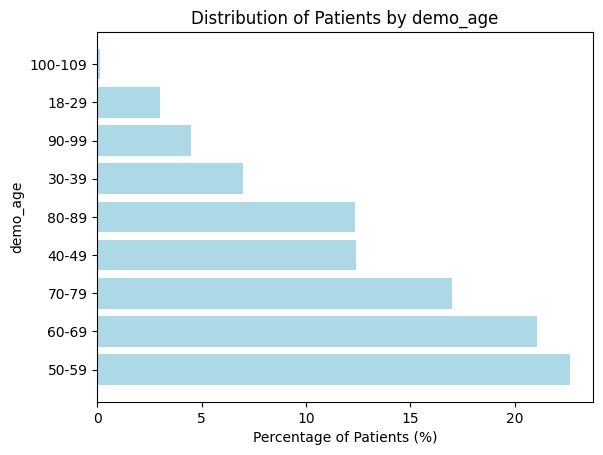

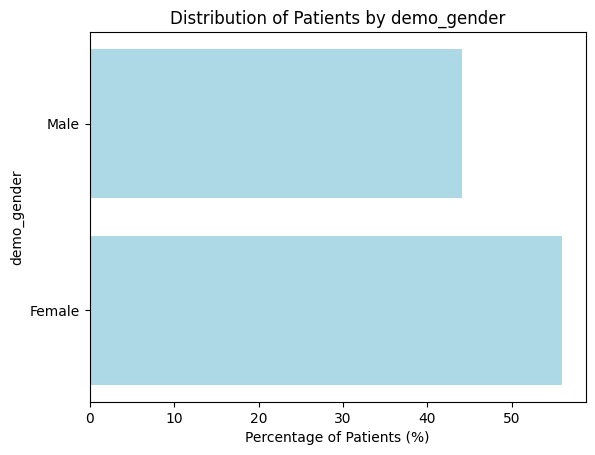

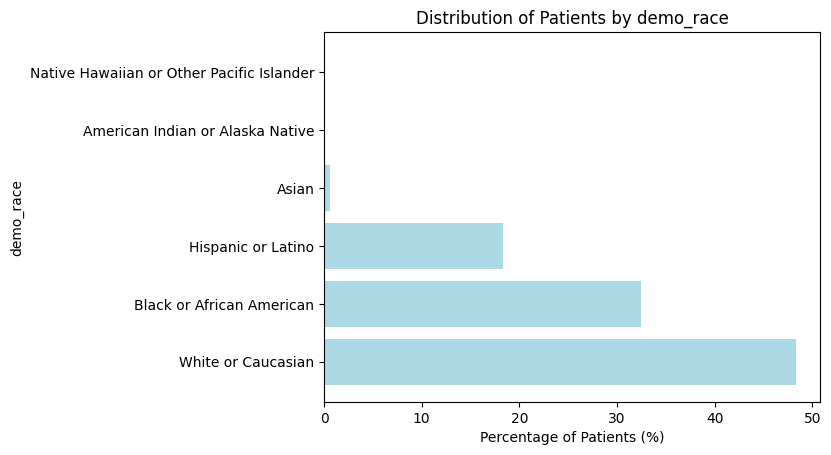

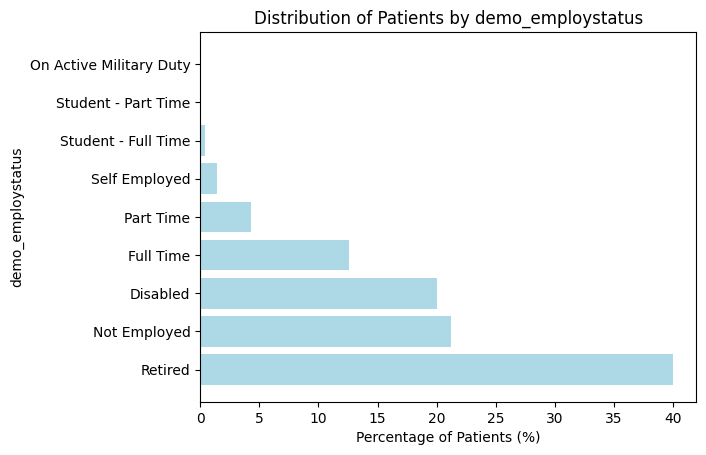

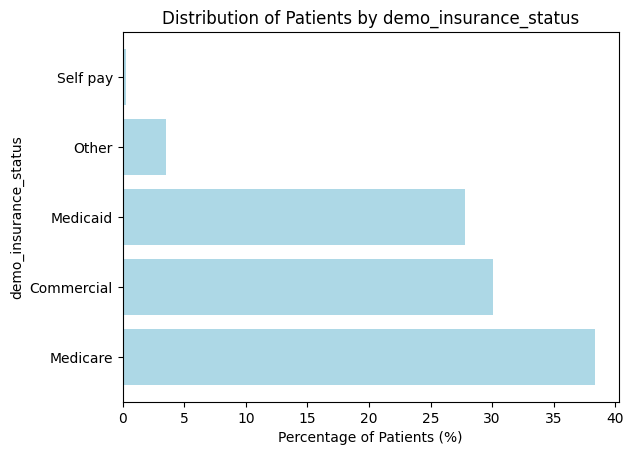

In [185]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `demographic` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [186]:
#Isolating columns of interest
columns_of_interest = demographic

In [187]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for demo_age:
demo_age
100-109     0.078578
18-29       0.722353
30-39       1.808250
40-49       3.761349
50-59       8.656878
60-69      10.040047
70-79       9.846914
80-89       8.034877
90-99       3.021955
dtype: float64


Percentage Admission for demo_gender:
demo_gender
Female    24.795744
Male      21.175457
dtype: float64


Percentage Admission for demo_race:
demo_race
American Indian or Alaska Native              0.049230
Asian                                         0.306740
Black or African American                    13.401876
Hispanic or Latino                            6.543781
Native Hawaiian or Other Pacific Islander     0.019881
White or Caucasian                           25.649692
dtype: float64


Percentage Admission for demo_employstatus:
demo_employstatus
Disabled                9.306333
Full Time               3.429994
Not Employed            7.373115
Part Time               1.093470
Retired                24.138715
Self Employed          

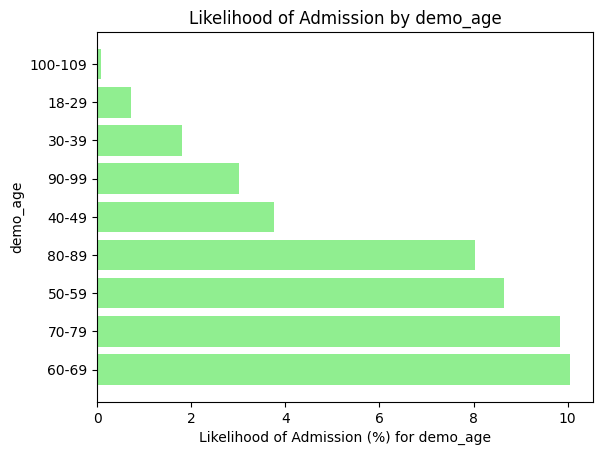

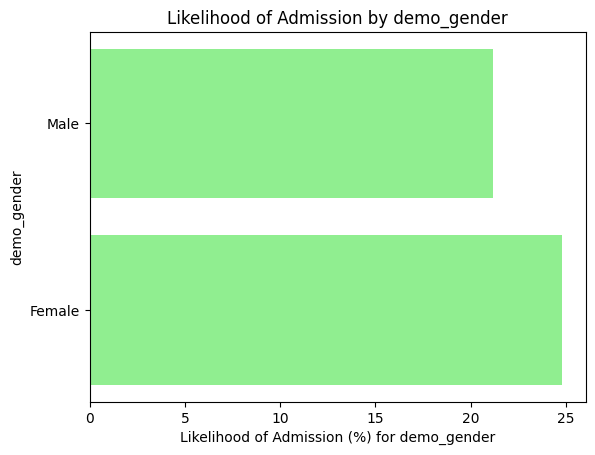

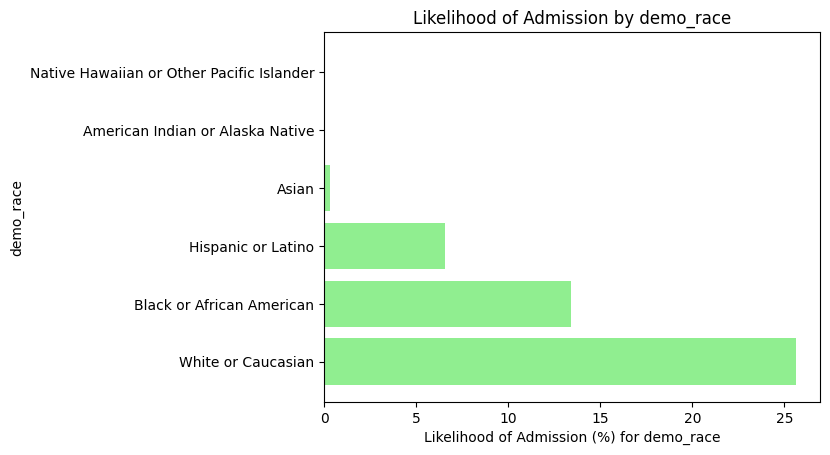

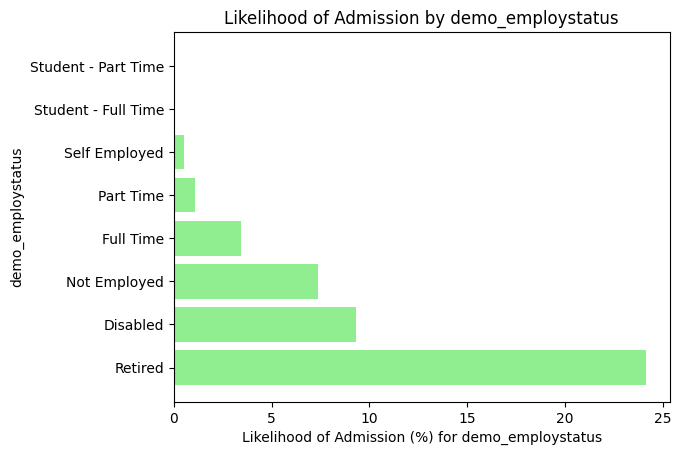

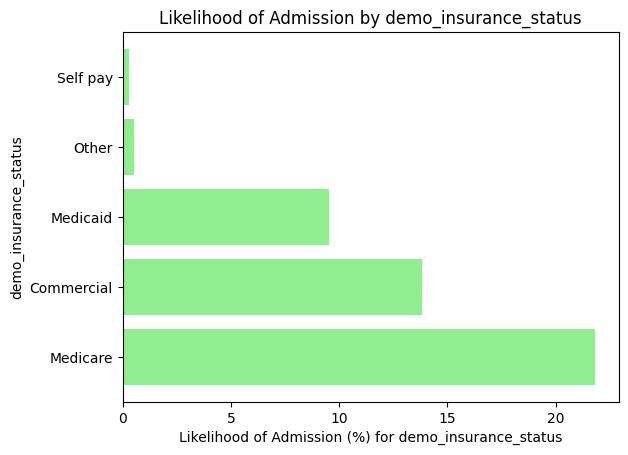

In [188]:

for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}
    
    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()


We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Demographic` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [189]:
#Establishing X and Y
X = health_data[demographic]
Y = health_data['disposition']

In [190]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


               Variable1    ChiSquare       P_Value
0               demo_age  7597.104463  0.000000e+00
1            demo_gender   147.909809  4.964168e-34
2              demo_race  2178.012234  0.000000e+00
3      demo_employstatus  7536.070484  0.000000e+00
4  demo_insurance_status  5342.894601  0.000000e+00


In [191]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

               Variable1    ChiSquare       P_Value
0               demo_age  7597.104463  0.000000e+00
3      demo_employstatus  7536.070484  0.000000e+00
4  demo_insurance_status  5342.894601  0.000000e+00
2              demo_race  2178.012234  0.000000e+00
1            demo_gender   147.909809  4.964168e-34


---
Key takeaways: 

#### Age:

- **Highest Population Occurrence:** 50-59 (22.60%)
- **Lowest Population Occurrence:** 100-109 (0.13%)

**Admission Rates:**
- Highest Admission Rate: 18-29 (0.72%)
- Lowest Admission Rate: 100-109 (0.08%)

**Disparities:**
- Disparity: Higher admission rate for 18-29 compared to the highest population occurrence (50-59), and lower admission rate for 100-109 compared to the lowest population occurrence.

#### Gender:

- **Highest Population Occurrence:** Female (55.98%)
- **Lowest Population Occurrence:** Male (44.02%)

**Admission Rates:**
- Highest Admission Rate: Female (24.82%)
- Lowest Admission Rate: Male (21.19%)

**Disparities:**
- Disparity: Higher admission rate for females compared to the highest population occurrence (Female), and lower admission rate for males compared to the lowest population occurrence (Male).

#### Race:

- **Highest Population Occurrence:** White or Caucasian (48.35%)
- **Lowest Population Occurrence:** Native Hawaiian or Other Pacific Islander (0.06%)

**Admission Rates:**
- Highest Admission Rate: White or Caucasian (25.68%)
- Lowest Admission Rate: Native Hawaiian or Other Pacific Islander (0.02%)

**Disparities:**
- Disparity: Higher admission rate for White or Caucasian compared to the highest population occurrence (White or Caucasian), and lower admission rate for Native Hawaiian or Other Pacific Islander compared to the lowest population occurrence.

##### Employment Status:

- **Highest Population Occurrence:** Retired (39.97%)
- **Lowest Population Occurrence:** On Active Military Duty (0.00%)

**Admission Rates:**
- Highest Admission Rate: Retired (24.16%)
- Lowest Admission Rate: On Active Military Duty (0.00%)

**Disparities:**
- Disparity: Higher admission rate for Retired compared to the highest population occurrence (Retired), and no admission for On Active Military Duty despite being the lowest population occurrence.

#### Insurance Status:

- **Highest Population Occurrence:** Medicare (38.39%)
- **Lowest Population Occurrence:** Self pay (0.28%)

**Admission Rates:**
- Highest Admission Rate: Medicare (21.84%)
- Lowest Admission Rate: Self pay (0.27%)

**Disparities:**
- Disparity: Higher admission rate for Medicare compared to the highest population occurrence (Medicare), and lower admission rate for Self pay compared to the lowest population occurrence.

#### Interpretation of Chi-Square Test:
- For `demo_age`, the high chi-square value (7572.65) and low p-value (0.00) suggest a strong association between age and admission rates. This indicates that different age groups are not occurring randomly concerning admission rates, and there's a significant relationship between age and the likelihood of admission.

- For `demo_employstatus`, the high chi-square value (7495.23) and low p-value (0.00) indicate a strong association between employment status and admission rates. Employment status and admission rates are not occurring randomly, suggesting a significant relationship between these factors.

- For `demo_insurance_status`, the high chi-square value (5291.14) and low p-value (0.00) suggest a strong association between insurance status and admission rates. Insurance status and admission rates are not occurring randomly, indicating a significant relationship between these factors.

- For `demo_race`, the high chi-square value (2195.91) and low p-value (0.00) suggest a strong association between race and admission rates. Race and admission rates are not occurring randomly, indicating a significant relationship between these factors.

- For `demo_gender`, the chi-square value (149.39) is lower, but the p-value (2.36e-34) is still well below the significance threshold of 0.05. This suggests a significant association between gender and admission rates, though the association is relatively weaker compared to other demographic factors.


---
#### <a id = 'tcat'></a> 1.3 Disposition vs Triage Categorical Variables

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `triage_cat` super-category. 

In [192]:
triage_cat = health_data.filter(like='triage_cat').columns
print(f'The columns that make up the demographic super category are : {triage_cat}')

The columns that make up the demographic super category are : Index(['triage_cat_arrivalmonth'], dtype='object')


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition?  
----

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `triage_cat` super column. What are the percentages of each unique entry from the whole? What is the distribution?

In [193]:
# Define the list of columns to analyze
columns_of_interest = triage_cat

In [194]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for triage_cat_arrivalmonth:
triage_cat_arrivalmonth
May          10.341106
June         10.242646
March        10.060875
April         9.902771
January       7.810503
July          7.687428
August        7.666600
December      7.501870
October       7.426132
September     7.391103
November      7.077736
February      6.891230
Name: count, dtype: float64




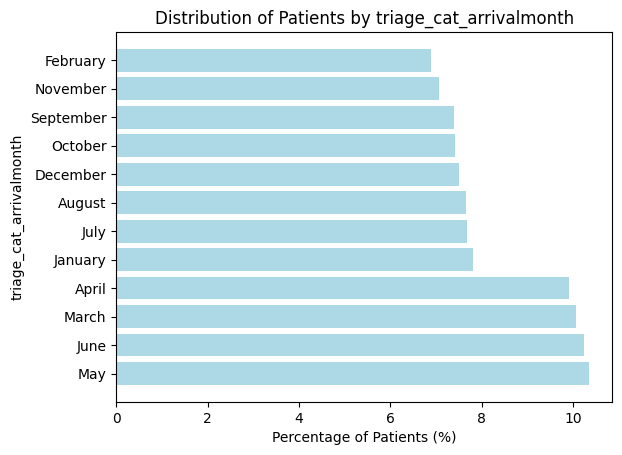

In [195]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `triage_cat` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [196]:
#Isolating columns of interest
columns_of_interest = triage_cat


In [197]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for triage_cat_arrivalmonth:
triage_cat_arrivalmonth
April        4.550920
August       3.474490
December     3.411060
February     3.253903
January      3.630700
July         3.480171
June         4.686302
March        4.764880
May          4.720384
November     3.208460
October      3.429047
September    3.360883
dtype: float64




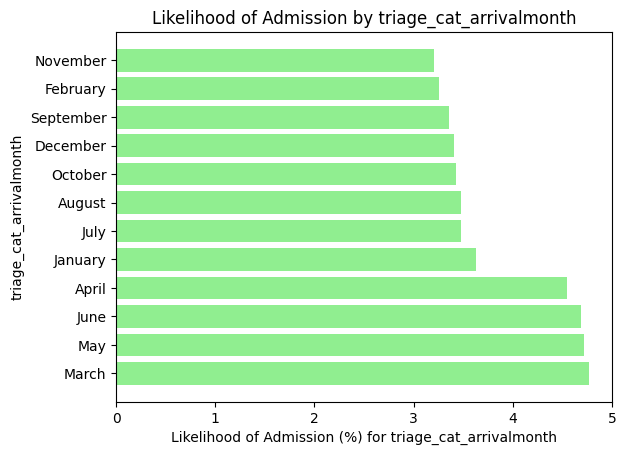

In [198]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Triage Categorical` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [199]:
#Establishing X and Y
X = health_data[triage_cat]
Y = health_data['disposition']

In [200]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                 Variable1  ChiSquare   P_Value
0  triage_cat_arrivalmonth  20.297329  0.041426


In [201]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

                 Variable1  ChiSquare   P_Value
0  triage_cat_arrivalmonth  20.297329  0.041426


I don't plan to keep this column after doing analysis since it will not be beneficial to my model. I plan to drop it.

In [202]:
health_data = health_data.drop(columns=columns_of_interest)

---
Key takeaways: 

#### Triage Category - Arrival Month:
- **Highest Population Occurrence:** May (10.34%)
- **Lowest Population Occurrence:** February (6.89%)

**Admission Rates:**
- Highest Admission Rate: March (4.77%)
- Lowest Admission Rate: February (3.26%)

**Disparities:**
- Disparity: Higher admission rate for March compared to the highest population occurrence (March), and lower admission rate for February compared to the lowest population occurrence.

#### Interpretation of Chi Square Test: 
- For `triage_cat_arrivalmonth`, the chi-square value (20.16) is lower, but the p-value (0.043) is still below the significance threshold of 0.05, indicating a significant association.


---
#### <a id = 'tnum'></a> 1.4 Disposition vs Triage Numerical Variables

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `Triage Numerical` super-category. 

In [203]:
triage_num = health_data.filter(like='triage_vita').columns
print(f'The columns that make up the demographic super category are : {triage_num}')

The columns that make up the demographic super category are : Index(['triage_vital_hr', 'triage_vital_sbp', 'triage_vital_dbp',
       'triage_vital_rr', 'triage_vital_temp', 'triage_vital_hr_imputed_flag',
       'triage_vital_sbp_imputed_flag', 'triage_vital_dbp_imputed_flag',
       'triage_vital_rr_imputed_flag', 'triage_vital_temp_imputed_flag'],
      dtype='object')


We previously converted these numerical columns into categorical columns for understandability. So even though these columns are categorical, we will still consider them to be numeric. 

We will not be looking into the imputed_flag as it will not provide any meaningful data given that these just indicate whether or not the numerical data was imputed or not. This will come into play for modelling.

In [204]:
triage_num = ['triage_vital_hr', 'triage_vital_sbp', 'triage_vital_dbp',
       'triage_vital_rr', 'triage_vital_temp'
      ]

First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition? 
______

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `triage_vital` super column. What are the percentages of each unique entry from the whole? What is the distribution?

In [205]:
# Define the list of columns to analyze
columns_of_interest = triage_num

In [206]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for triage_vital_hr:
triage_vital_hr
normal_hr               85.940148
tachycardia(high)_hr    11.678832
bradycardia(low)_hr      2.340311
critical_hr              0.040709
Name: count, dtype: float64


Percentage Distribution for triage_vital_sbp:
triage_vital_sbp
hypertension(high)_sbp    48.451627
pre-hypertension_sbp      33.904210
normal_sbp                13.492762
critical_sbp               3.554016
hypotension(low)_sbp       0.597385
Name: count, dtype: float64


Percentage Distribution for triage_vital_dbp:
triage_vital_dbp
normal_dbp                51.875941
pre-hypertension_dbp      28.942411
hypertension(high)_dbp    13.831691
hypotension(low)_dbp       4.603936
critical_dpb               0.746021
Name: count, dtype: float64


Percentage Distribution for triage_vital_rr:
triage_vital_rr
normal_rr             97.356736
tachypnea(high)_rr     2.480426
Critical_rr            0.138222
bradypnea(low)_rr      0.024615
Name: count, dtype: float64


Percenta

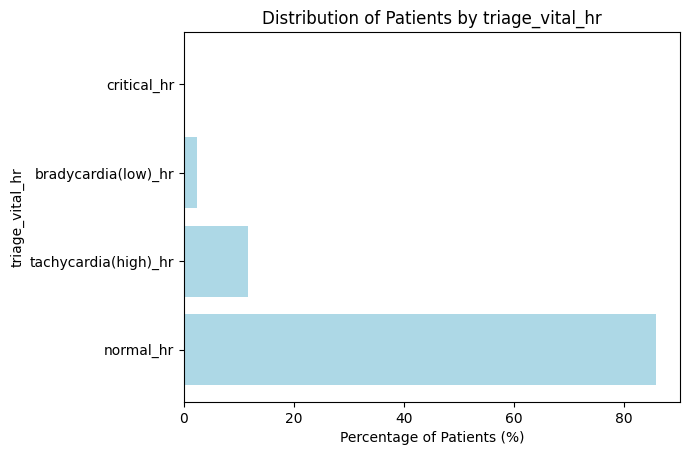

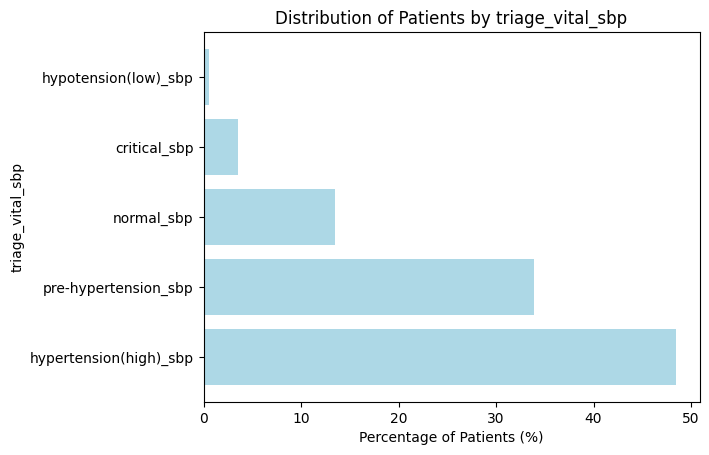

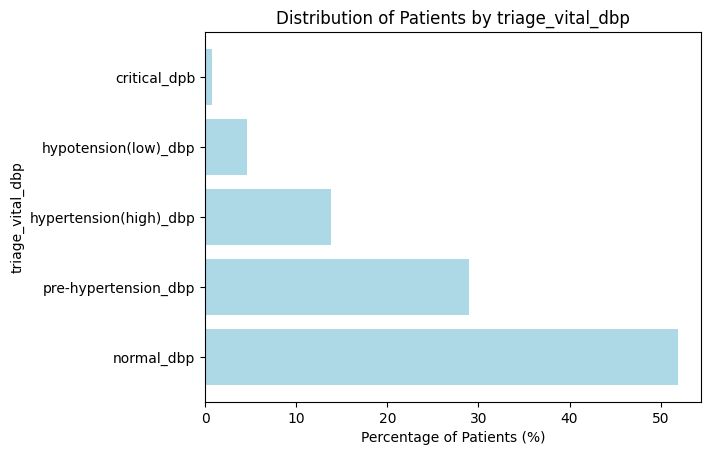

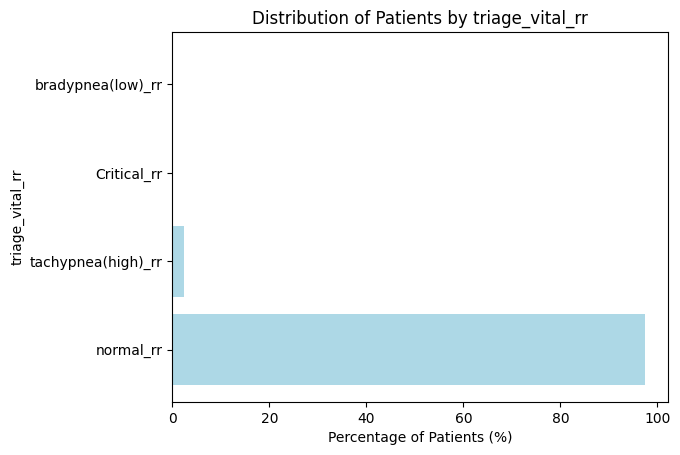

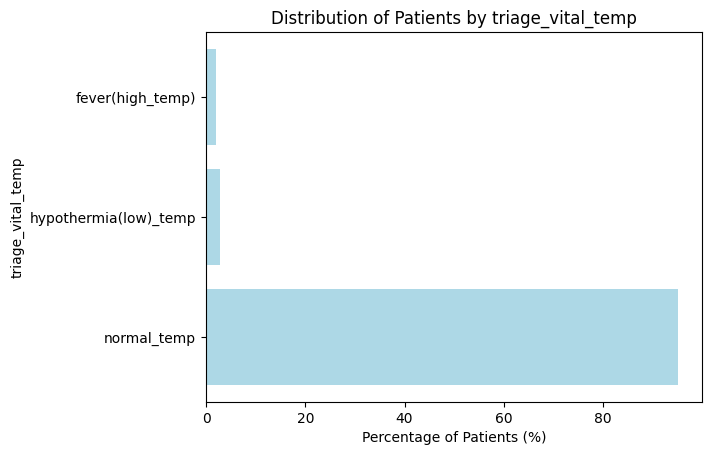

In [207]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `triage_vital` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [208]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for triage_vital_hr:
triage_vital_hr
bradycardia(low)_hr      1.093470
critical_hr              0.032189
normal_hr               39.051568
tachycardia(high)_hr     5.793973
dtype: float64


Percentage Admission for triage_vital_sbp:
triage_vital_sbp
critical_sbp               1.638786
hypertension(high)_sbp    24.828879
hypotension(low)_sbp       0.479991
normal_sbp                 5.855510
pre-hypertension_sbp      13.168035
dtype: float64


Percentage Admission for triage_vital_dbp:
triage_vital_dbp
critical_dpb               0.444962
hypertension(high)_dbp     4.765827
hypotension(low)_dbp       2.843023
normal_dbp                27.200432
pre-hypertension_dbp      10.716957
dtype: float64


Percentage Admission for triage_vital_rr:
triage_vital_rr
Critical_rr            0.113607
bradypnea(low)_rr      0.016094
normal_rr             44.285079
tachypnea(high)_rr     1.556420
dtype: float64


Percentage Admission for triage_vital_temp:
triage_vital_temp
fever(high

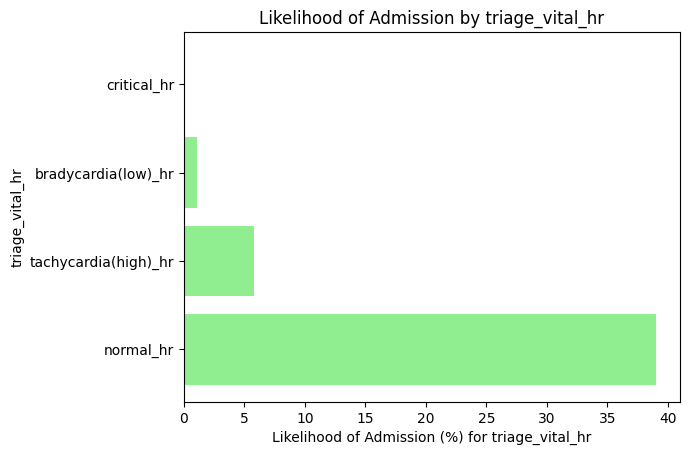

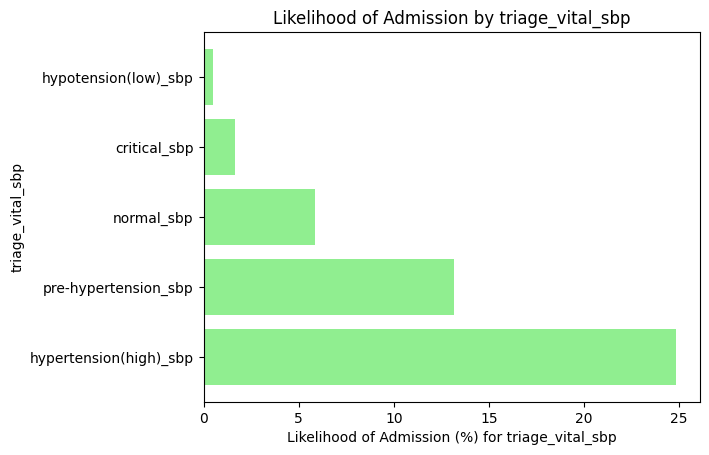

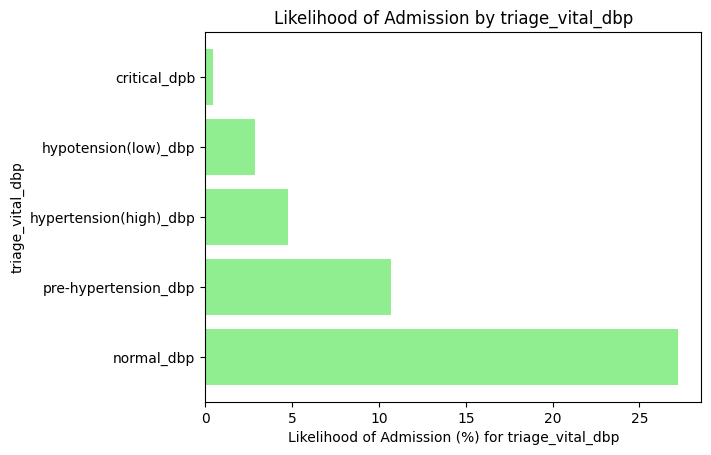

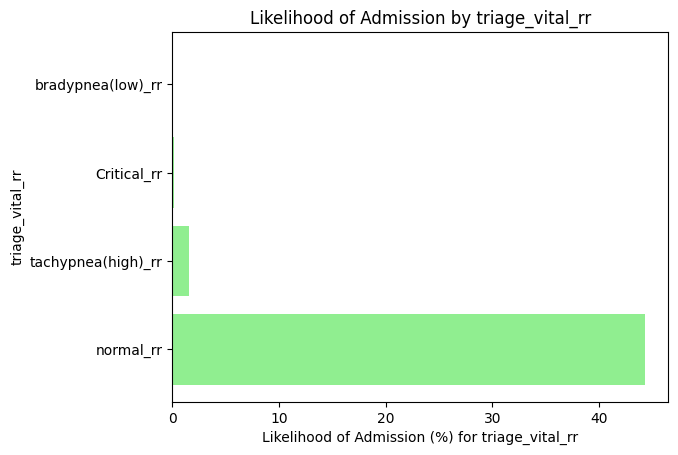

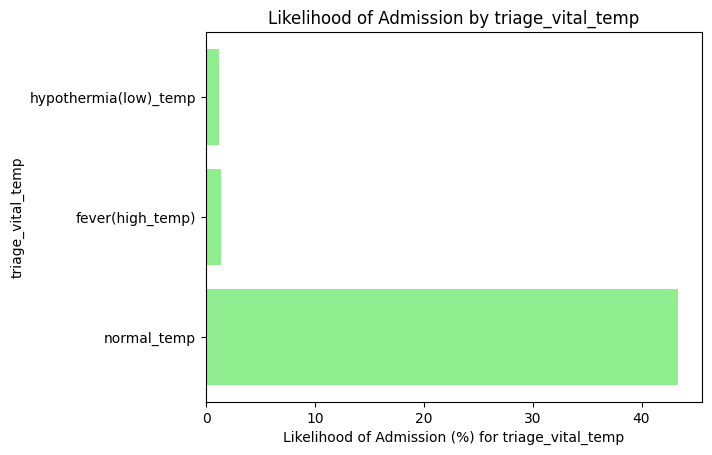

In [209]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Triage Numerical` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [210]:
#Establishing X and Y
X = health_data[triage_num]
Y = health_data['disposition']

In [211]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


           Variable1    ChiSquare        P_Value
0    triage_vital_hr    95.620314   1.358315e-20
1   triage_vital_sbp  1644.746101   0.000000e+00
2   triage_vital_dbp  3232.545507   0.000000e+00
3    triage_vital_rr   387.654186   1.045301e-83
4  triage_vital_temp   476.256914  3.820544e-104


In [212]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

           Variable1    ChiSquare        P_Value
2   triage_vital_dbp  3232.545507   0.000000e+00
1   triage_vital_sbp  1644.746101   0.000000e+00
4  triage_vital_temp   476.256914  3.820544e-104
3    triage_vital_rr   387.654186   1.045301e-83
0    triage_vital_hr    95.620314   1.358315e-20


---
Key takeaways: 

#### Triage Vital Sign - Heart Rate:
- **Highest Population Occurrence:** Normal Heart Rate (85.92%)
- **Lowest Population Occurrence:** Critical Heart Rate (0.04%)

**Admission Rates:**
- Highest Admission Rate: Normal Heart Rate (39.08%)
- Lowest Admission Rate: Critical Heart Rate (0.03%)

**Disparities:**
- Disparity: Higher admission rate for Normal Heart Rate compared to the highest population occurrence (Normal Heart Rate), and much lower admission rate for Critical Heart Rate compared to the lowest population occurrence.

#### Triage Vital Sign - Systolic Blood Pressure:
- **Highest Population Occurrence:** Hypertension (High) SBP (48.47%)
- **Lowest Population Occurrence:** Hypotension (Low) SBP (0.60%)

**Admission Rates:**
- Highest Admission Rate: Hypertension (High) SBP (24.85%)
- Lowest Admission Rate: Hypotension (Low) SBP (0.48%)

**Disparities:**
- Disparity: Higher admission rate for Hypertension (High) SBP compared to the highest population occurrence (Hypertension (High) SBP), and much lower admission rate for Hypotension (Low) SBP compared to the lowest population occurrence.

#### Triage Vital Sign - Diastolic Blood Pressure:
- **Highest Population Occurrence:** Normal DBP (51.88%)
- **Lowest Population Occurrence:** Critical DBP (0.74%)

**Admission Rates:**
- Highest Admission Rate: Normal DBP (27.22%)
- Lowest Admission Rate: Critical DBP (0.44%)

**Disparities:**
- Disparity: Higher admission rate for Normal DBP compared to the highest population occurrence (Normal DBP), and much lower admission rate for Critical DBP compared to the lowest population occurrence.

#### Triage Vital Sign - Respiratory Rate:
- **Highest Population Occurrence:** Normal Respiratory Rate (97.35%)
- **Lowest Population Occurrence:** Bradypnea (Low) RR (0.02%)

**Admission Rates:**
- Highest Admission Rate: Normal Respiratory Rate (44.32%)
- Lowest Admission Rate: Bradypnea (Low) RR (0.02%)

**Disparities:**
- Disparity: Higher admission rate for Normal Respiratory Rate compared to the highest population occurrence (Normal Respiratory Rate), and much lower admission rate for Bradypnea (Low) RR compared to the lowest population occurrence.

#### Triage Vital Sign - Body Temperature:
- **Highest Population Occurrence:** Normal Temperature (95.18%)
- **Lowest Population Occurrence:** Fever (High) Temperature (2.01%)

**Admission Rates:**
- Highest Admission Rate: Normal Temperature (43.43%)
- Lowest Admission Rate: Fever (High) Temperature (1.39%)

**Disparities:**
- Disparity: Higher admission rate for Normal Temperature compared to the highest population occurrence (Normal Temperature), and much lower admission rate for Fever (High) Temperature compared to the lowest population occurrence.

#### Interpretation of Chi-Square Test: 
- For `triage_vital_dbp`, the high chi-square value (3217.93) and low p-value (0.00) suggest a strong association.
- For `triage_vital_sbp`, the high chi-square value (1630.35) and low p-value (0.00) suggest a strong association.
- For `triage_vital_temp`, the chi-square value (473.45) is higher, and the p-value (1.56e-103) is much below the significance threshold of 0.05


---
#### <a id = 'huse'></a> 1.5 Disposition vs Hospital Usage

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `Hospital Usage` super-category. 

In [213]:
hos_usage = health_data.filter(like='huse_').columns
print(f'The columns that make up the demographic super category are : {hos_usage}')

The columns that make up the demographic super category are : Index(['huse_previousdispo', 'huse_n_edvisits', 'huse_n_admissions',
       'huse_n_surgeries'],
      dtype='object')


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition? 
____

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `Hospital Usage` super column. What are the percentages of each unique entry from the whole? What is the distribution?

In [214]:
# Define the list of columns to analyze
columns_of_interest = hos_usage

In [215]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for huse_previousdispo:
huse_previousdispo
Discharge                       42.838479
Admit                           36.883562
No previous dispo               17.641323
Transfer to Another Facility     1.029093
LWBS after Triage                0.612533
AMA                              0.601172
Eloped                           0.219641
LWBS before Triage               0.095619
Observation                      0.070058
Send to L&D                      0.008521
Name: count, dtype: float64


Percentage Distribution for huse_n_edvisits:
huse_n_edvisits
low_prior_visit         63.127799
no_prior_visits         25.948858
moderate_prior_visit     9.912238
high_prior_visit         1.011105
Name: count, dtype: float64


Percentage Distribution for huse_n_admissions:
huse_n_admissions
low_prior_admis         49.308415
No_prior_admis          47.970689
moderate_prior_admis     2.315696
high_prior_admis         0.266977
vhigh_prior_admis        0.138222
Name: count, dtype: f

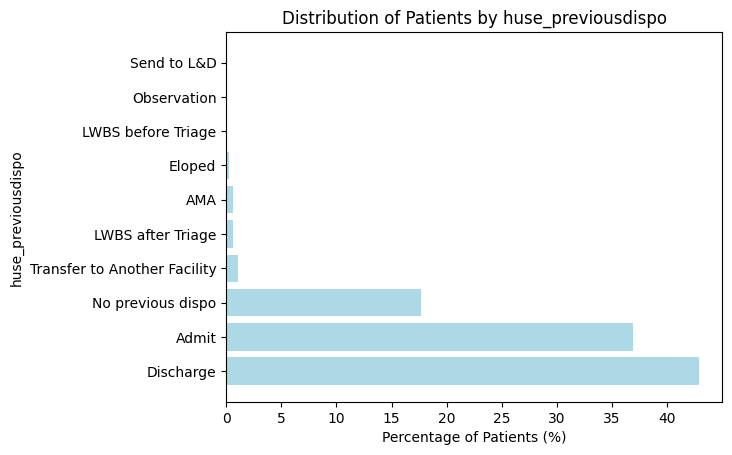

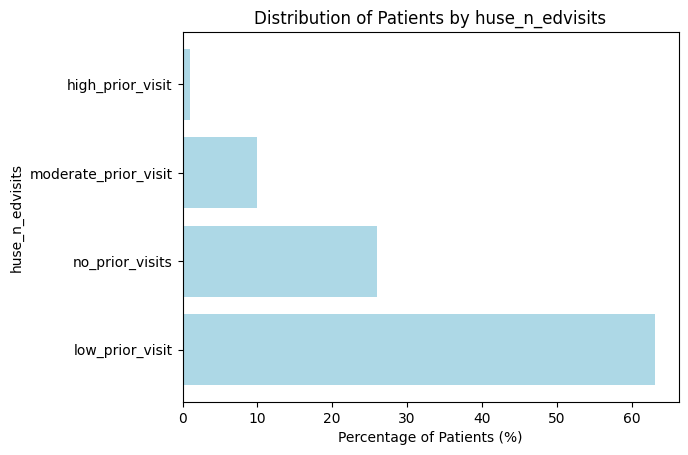

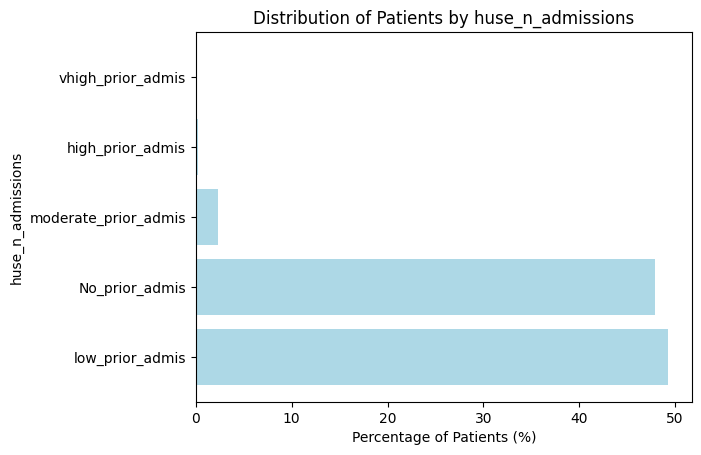

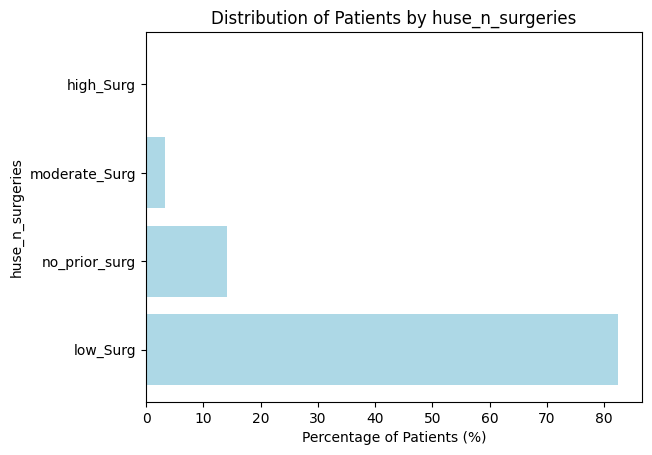

In [216]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `hospital usage` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [217]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for huse_previousdispo:
huse_previousdispo
AMA                              0.269817
Admit                           23.222282
Discharge                       13.796662
Eloped                           0.063431
LWBS after Triage                0.187452
LWBS before Triage               0.026508
No previous dispo                7.926004
Observation                      0.034082
Send to L&D                      0.001893
Transfer to Another Facility     0.443069
dtype: float64


Percentage Admission for huse_n_edvisits:
huse_n_edvisits
high_prior_visit         0.188399
low_prior_visit         30.048188
moderate_prior_visit     4.023592
no_prior_visits         11.711021
dtype: float64


Percentage Admission for huse_n_admissions:
huse_n_admissions
No_prior_admis          17.398960
high_prior_admis         0.161890
low_prior_admis         26.968483
moderate_prior_admis     1.368021
vhigh_prior_admis        0.073845
dtype: float64


Percentage Admission for huse_n_surgeri

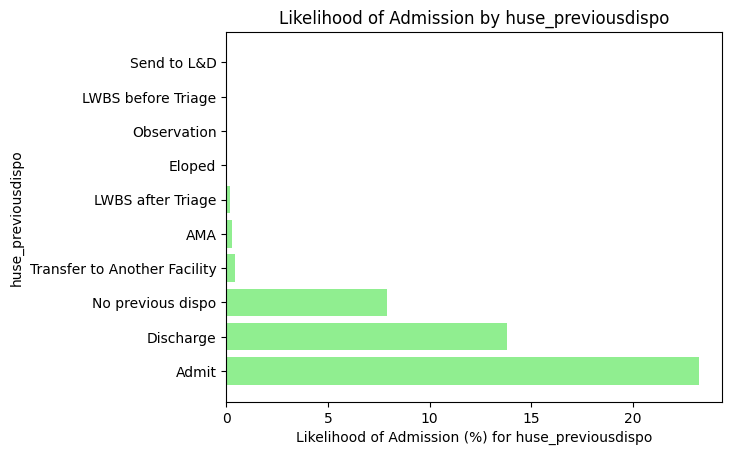

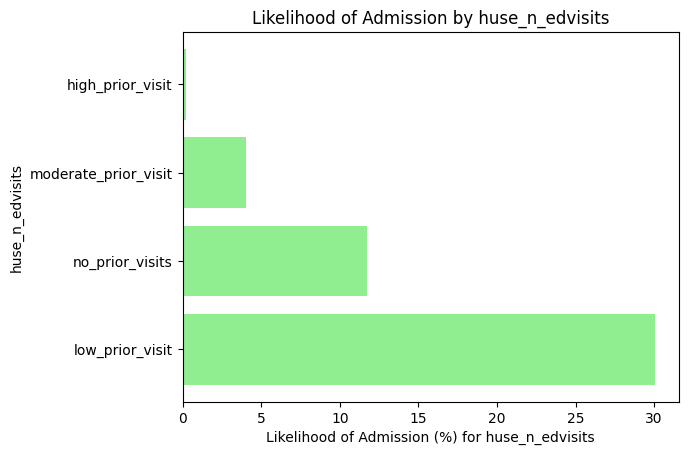

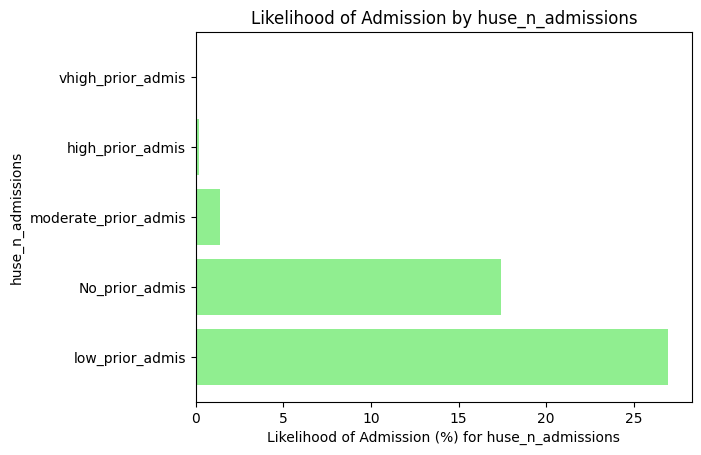

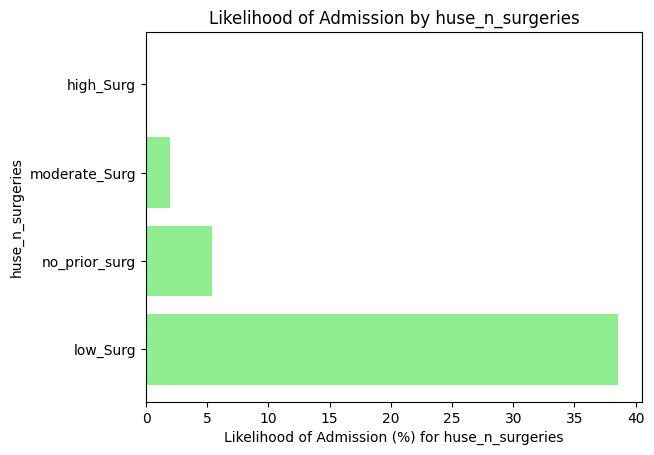

In [218]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Hospital Usage` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [219]:
#Establishing X and Y
X = health_data[hos_usage]
Y = health_data['disposition']

In [220]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


            Variable1    ChiSquare        P_Value
0  huse_previousdispo  8096.297071   0.000000e+00
1     huse_n_edvisits   522.255341  7.168104e-113
2   huse_n_admissions  3712.081398   0.000000e+00
3    huse_n_surgeries   595.279572  1.063437e-128


In [221]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

            Variable1    ChiSquare        P_Value
0  huse_previousdispo  8096.297071   0.000000e+00
2   huse_n_admissions  3712.081398   0.000000e+00
3    huse_n_surgeries   595.279572  1.063437e-128
1     huse_n_edvisits   522.255341  7.168104e-113


---
Key takeaways: 

#### Patient History and Utilization:
- **Previous Disposition:**
  - **Highest Population Occurrence:** Discharge (42.82%)
  - **Lowest Population Occurrence:** Send to L&D (0.01%)
  
  **Admission Rates:**
  - Highest Admission Rate: Admit (23.24%)
  - Lowest Admission Rate: Send to L&D (0.00%)

  **Disparities:**
  - Disparity: Higher admission rate for Admit compared to the highest population occurrence (Admit), and much lower admission rate for Send to L&D compared to the lowest population occurrence.

- **Number of ED Visits:**
  - **Highest Population Occurrence:** Low Prior Visits (63.10%)
  - **Lowest Population Occurrence:** High Prior Visits (1.02%)

  **Admission Rates:**
  - Highest Admission Rate: Low Prior Visits (30.07%)
  - Lowest Admission Rate: High Prior Visits (0.19%)

  **Disparities:**
  - Disparity: Higher admission rate for Low Prior Visits compared to the highest population occurrence (Low Prior Visits), and much lower admission rate for High Prior Visits compared to the lowest population occurrence.

- **Number of Admissions:**
  - **Highest Population Occurrence:** Low Prior Admissions (49.28%)
  - **Lowest Population Occurrence:** Very High Prior Admissions (0.14%)

  **Admission Rates:**
  - Highest Admission Rate: Low Prior Admissions (26.98%)
  - Lowest Admission Rate: Very High Prior Admissions (0.07%)

  **Disparities:**
  - Disparity: Higher admission rate for Low Prior Admissions compared to the highest population occurrence (Low Prior Admissions), and much lower admission rate for Very High Prior Admissions compared to the lowest population occurrence.

- **Number of Surgeries:**
  - **Highest Population Occurrence:** Low Prior Surgeries (82.52%)
  - **Lowest Population Occurrence:** High Prior Surgeries (0.06%)

  **Admission Rates:**
  - Highest Admission Rate: Low Prior Surgeries (38.64%)
  - Lowest Admission Rate: High Prior Surgeries (0.04%)

  **Disparities:**
  - Disparity: Higher admission rate for Low Prior Surgeries compared to the highest population occurrence (Low Prior Surgeries), and much lower admission rate for High Prior Surgeries compared to the lowest population occurrence.

#### Interpretation of Chi-Square Test: 
- For `huse_previousdispo`, the high chi-square value (8063.54) and low p-value (0.00) suggest a strong association.
- For `huse_n_admissions`, the high chi-square value (3709.72) and low p-value (0.00) suggest a strong association.
- For `huse_n_surgeries`, the chi-square value (609.88) is higher, and the p-value (7.27e-132) is much below the significance threshold of 0.05.
- For `huse_n_edvisits`, the chi-square value (524.73) is higher, and the p-value (2.09e-113) is much below the significance threshold of 0.05.


---
#### <a id = 'cc'></a> 1.6 Disposition vs Chief Complaint

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `Chief Complaint` super-category. 

In [222]:
chief_complaint = health_data.filter(like='cc_').columns
print(f'The columns that make up the demographic super category are : {chief_complaint}')

The columns that make up the demographic super category are : Index(['cc_abdominalcramping', 'cc_abdominaldistention', 'cc_abdominalpain',
       'cc_abdominalpainpregnant', 'cc_abnormallab', 'cc_abscess',
       'cc_addictionproblem', 'cc_agitation', 'cc_alcoholintoxication',
       'cc_alcoholproblem',
       ...
       'cc_vaginaldischarge', 'cc_vaginalpain', 'cc_weakness', 'cc_wheezing',
       'cc_withdrawal-alcohol', 'cc_woundcheck', 'cc_woundinfection',
       'cc_woundre-evaluation', 'cc_wristinjury', 'cc_wristpain'],
      dtype='object', length=200)


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition? 
____

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `Chief Complaint` super column. What are the percentages of each unique entry from the whole? What is the distribution?

Given that there are 200 columns, it may be difficult to create an appropriate visual to really understand this. It may be easier just to create a list of percentages. 



In [223]:
# Define the group of columns you want to analyze ('chief_complaint' columns)
chief_complaint_columns = health_data.filter(like='cc_')

# Create an empty dictionary to store the results
percentage_results = {}

# Loop through each column in the group
for column_name in chief_complaint_columns.columns:
    # Calculate the percentage of 1s in the current column
    percentage = (chief_complaint_columns[column_name] == 1).sum() / len(health_data) * 100
    # Store the result in the dictionary
    percentage_results[column_name] = percentage

# Convert the results to a DataFrame for easier analysis
results_df = pd.DataFrame(percentage_results.items(), columns=['Variable', 'Percentage of Occurrence'])

# Sort the results by the percentage in descending order
results_df = results_df.sort_values(by='Percentage of Occurrence', ascending=False)

In [224]:
top_20 = results_df.head(20)
print(top_20)

                              Variable  Percentage of Occurrence
2                     cc_abdominalpain                  9.047876
31                        cc_chestpain                  8.513922
142                           cc_other                  8.481733
163               cc_shortnessofbreath                  6.790877
71                             cc_fall                  3.967736
21                         cc_backpain                  3.292719
46                        cc_dizziness                  2.845863
11              cc_alteredmentalstatus                  2.570366
119                         cc_legpain                  2.340311
38                            cc_cough                  2.334630
57                           cc_emesis                  2.239958
192                        cc_weakness                  2.239011
72                          cc_fall>65                  1.953099
8               cc_alcoholintoxication                  1.951206
82                       

In [225]:
bottom_20 = results_df.tail(20)
print(bottom_20)

                    Variable  Percentage of Occurrence
190      cc_vaginaldischarge                  0.048283
0       cc_abdominalcramping                  0.047336
68       cc_faciallaceration                  0.046390
155        cc_rectalbleeding                  0.046390
148            cc_pelvicpain                  0.044496
194    cc_withdrawal-alcohol                  0.043549
131       cc_motorcyclecrash                  0.043549
175  cc_swallowedforeignbody                  0.042603
30             cc_cellulitis                  0.042603
183                cc_trauma                  0.037869
179           cc_thumbinjury                  0.035029
180           cc_tickremoval                  0.031242
36         cc_conjunctivitis                  0.031242
171              cc_stdcheck                  0.030295
166        cc_sicklecellpain                  0.024615
24      cc_bodyfluidexposure                  0.021775
87       cc_foreignbodyineye                  0.017988
162       

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `Chief Complaint` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries? We will be using phi coefficients as it measures the strength and direction of the association between two binary variables. Given that the target variable, disposition, is binary and so are the `Chief Complaint` columns, it was decided that this would be the best one to use. We will look at the coefficient to determine the relationship that exists between the given `Chief Complaint` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [226]:
#Establishing X and Y
X = health_data[chief_complaint]
Y = health_data['disposition']

In [227]:
# Create an empty list to store the results
results = []

# Generate all pairwise combinations of binary columns from X and Y
binary_columns_X = X.columns.tolist()
binary_columns_Y = ['disposition']
combinations = list(itertools.product(binary_columns_X, binary_columns_Y))

# Calculate Phi coefficients and p-values for each combination
for var1, var2 in combinations:
    contingency_table = pd.crosstab(health_data[var1], health_data[var2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    n = len(health_data)
    phi_coefficient = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
    results.append((var1, phi_coefficient, p))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Variable1', 'Phi_Coefficient', 'P_Value'])

# Display the DataFrame
print(results_df)

                                   Variable1  Phi_Coefficient        P_Value
0                       cc_abdominalcramping         0.004623   3.361523e-02
1                     cc_abdominaldistention         0.013686   3.165510e-10
2                           cc_abdominalpain         0.015547   8.940079e-13
3                   cc_abdominalpainpregnant         0.014719   1.331186e-11
4                             cc_abnormallab         0.047306  8.057505e-105
5                                 cc_abscess         0.024104   1.593424e-28
6                        cc_addictionproblem         0.008320   1.312498e-04
7                               cc_agitation         0.001437   5.089420e-01
8                     cc_alcoholintoxication         0.058168  1.825246e-157
9                          cc_alcoholproblem         0.017442   1.086866e-15
10                       cc_allergicreaction         0.018164   6.915596e-17
11                    cc_alteredmentalstatus         0.088564   0.000000e+00

In [228]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='P_Value', ascending=True)

sorted_df.head(20)

,Variable1,Phi_Coefficient,P_Value
163,cc_shortnessofbreath,0.114522,0.000000e+00
11,cc_alteredmentalstatus,0.088564,0.000000e+00
31,cc_chestpain,0.072643,2.033626e-244
132,cc_motorvehiclecrash,0.063772,7.530470e-189
192,cc_weakness,0.061673,9.310440e-177
8,cc_alcoholintoxication,0.058168,1.825246e-157
21,cc_backpain,0.057689,6.491519e-155
172,cc_strokealert,0.050563,1.796841e-119
4,cc_abnormallab,0.047306,8.057505e-105
77,cc_fever-9weeksto74years,0.044702,8.377230e-94


In [229]:
# Assuming 'P_Value' is a column in your DataFrame
columns_with_high_p_value = results_df[results_df['P_Value'] > 0.05].index

# Count the number of columns with P_Value > 0.05
num_columns_high_p_value = len(columns_with_high_p_value)

print(f"Number of columns with P-Value > 0.05: {num_columns_high_p_value}")


Number of columns with P-Value > 0.05: 27


We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Chief Complaint` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [230]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                                   Variable1    ChiSquare        P_Value
0                       cc_abdominalcramping     4.514168   3.361523e-02
1                     cc_abdominaldistention    39.569736   3.165510e-10
2                           cc_abdominalpain    51.064048   8.940079e-13
3                   cc_abdominalpainpregnant    45.768028   1.331186e-11
4                             cc_abnormallab   472.755293  8.057505e-105
5                                 cc_abscess   122.735406   1.593424e-28
6                        cc_addictionproblem    14.623752   1.312498e-04
7                               cc_agitation     0.436242   5.089420e-01
8                     cc_alcoholintoxication   714.781941  1.825246e-157
9                          cc_alcoholproblem    64.266343   1.086866e-15
10                       cc_allergicreaction    69.696864   6.915596e-17
11                    cc_alteredmentalstatus  1656.969565   0.000000e+00
12                             cc_animalbite    47.

In [231]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

sorted_df.head(20)

,Variable1,ChiSquare,P_Value
163,cc_shortnessofbreath,2770.629301,0.000000e+00
11,cc_alteredmentalstatus,1656.969565,0.000000e+00
31,cc_chestpain,1114.772107,2.033626e-244
132,cc_motorvehiclecrash,859.129427,7.530470e-189
192,cc_weakness,803.509797,9.310440e-177
8,cc_alcoholintoxication,714.781941,1.825246e-157
21,cc_backpain,703.050539,6.491519e-155
172,cc_strokealert,540.096176,1.796841e-119
4,cc_abnormallab,472.755293,8.057505e-105
77,cc_fever-9weeksto74years,422.133349,8.377230e-94


In [232]:
# Assuming 'P_Value' is a column in your DataFrame
columns_with_high_p_value = results_df[results_df['P_Value'] > 0.05]['Variable1'].tolist()

# Count the number of columns with P_Value > 0.05
num_columns_high_p_value = len(columns_with_high_p_value)

print(f"Number of columns with P-Value > 0.05: {num_columns_high_p_value}")
print(f"Columns with P-Value > 0.05: {columns_with_high_p_value}")


Number of columns with P-Value > 0.05: 27
Columns with P-Value > 0.05: ['cc_agitation', 'cc_armswelling', 'cc_blurredvision', 'cc_breathingproblem', 'cc_cellulitis', 'cc_chesttightness', 'cc_chills', 'cc_hallucinations', 'cc_hematuria', 'cc_homicidal', 'cc_hyperglycemia', 'cc_influenza', 'cc_ingestion', 'cc_medicalproblem', 'cc_motorcyclecrash', 'cc_numbness', 'cc_oralswelling', 'cc_overdose-accidental', 'cc_palpitations', 'cc_poisoning', 'cc_post-opproblem', 'cc_psychiatricevaluation', 'cc_psychoticsymptoms', 'cc_seizures', 'cc_sicklecellpain', 'cc_swallowedforeignbody', 'cc_trauma']


Given that these columns didn't meet the threshold, I'll do some feature engineering and drop these columns to reduce dimensionality. 

In [233]:
#Dropping columns with high p-value
health_data = health_data.drop(columns=columns_with_high_p_value)

---
Key takeaways: 

#### Medical Conditions Analysis

#### Top 20 Medical Conditions by Percentage of Occurrence:
| Variable                 | Percentage of Occurrence |
|--------------------------|---------------------------|
| cc_abdominalpain         | 9.07%                     |
| cc_chestpain             | 8.52%                     |
| cc_other                 | 8.34%                     |
| cc_shortnessofbreath     | 6.79%                     |
| cc_fall                  | 3.97%                     |
| cc_backpain              | 3.30%                     |
| cc_dizziness             | 2.85%                     |
| cc_alteredmentalstatus   | 2.58%                     |
| cc_legpain               | 2.35%                     |
| cc_cough                 | 2.34%                     |
| cc_emesis                | 2.25%                     |
| cc_weakness              | 2.24%                     |
| cc_fall>65               | 1.96%                     |
| cc_alcoholintoxication   | 1.96%                     |
| cc_flankpain             | 1.48%                     |
| cc_elevatedbloodsugar... | 1.37%                     |
| cc_motorvehiclecrash     | 1.35%                     |
| cc_headache-newonset...  | 1.31%                     |
| cc_abnormallab           | 1.31%                     |
| cc_medicalproblem        | 1.24%                     |

#### Bottom 20 Medical Conditions by Percentage of Occurrence:
| Variable              | Percentage of Occurrence |
|-----------------------|---------------------------|
| cc_vaginaldischarge   | 0.05%                     |
| cc_abdominalcramping  | 0.05%                     |
| cc_rectalbleeding     | 0.05%                     |
| cc_faciallaceration   | 0.05%                     |
| cc_pelvicpain         | 0.04%                     |
| cc_motorcyclecrash    | 0.04%                     |
| cc_withdrawal-alcohol | 0.04%                     |
| cc_swallowedforeign...| 0.04%                     |
| cc_cellulitis         | 0.04%                     |
| cc_trauma             | 0.04%                     |
| cc_thumbinjury        | 0.04%                     |
| cc_tickremoval        | 0.03%                     |
| cc_conjunctivitis     | 0.03%                     |
| cc_stdcheck           | 0.03%                     |
| cc_sicklecellpain     | 0.02%                     |
| cc_bodyfluidexposure  | 0.02%                     |
| cc_foreignbodyineye   | 0.02%                     |
| cc_seizures           | 0.01%                     |
| cc_exposuretostd      | 0.01%                     |
| cc_ingestion          | 0.01%                     |

#### Top 20 Medical Conditions by Association Strength:
| Variable1              | Phi Coefficient | P-Value       |
|------------------------|-----------------|---------------|
| cc_shortnessofbreath   | 0.11            | 0.00          |
| cc_alteredmentalstatus | 0.09            | 0.00          |
| cc_chestpain           | 0.07            | 1.03e-241     |
| cc_motorvehiclecrash   | 0.06            | 1.59e-189     |
| cc_weakness            | 0.06            | 1.15e-175     |
| cc_alcoholintoxication | 0.06            | 1.54e-157     |
| cc_backpain            | 0.06            | 5.03e-155     |
| cc_strokealert         | 0.05            | 9.55e-118     |
| cc_abnormallab         | 0.05            | 3.94e-104     |
| cc_kneepain            | 0.04            | 1.64e-93      |
| cc_fever-9weeksto74...| 0.04            | 1.58e-92      |
| cc_rash                | 0.04            | 1.25e-90      |
| cc_sorethroat          | 0.04            | 1.51e-77      |
| cc_gibleeding          | 0.04            | 9.93e-74      |
| cc_breathingdifficulty | 0.04            | 8.24e-73      |
| cc_emesis              | 0.04            | 3.80e-72      |
| cc_fatigue             | 0.04            | 1.80e-68      |
| cc_hypotension         | 0.04            | 2.21e-68      |
| cc_dyspnea             | 0.04            | 1.83e-66      |
| cc_footpain            | 0.04            | 5.60e-64      |

#### Interpretation:
- Conditions like abdominal pain, chest pain, and shortness of breath are highly prevalent in the dataset.
- Medical conditions associated with higher Phi coefficients indicate a stronger association with the dataset, and the p-values confirm the statistical significance of these associations.


---
#### <a id = 'pmh'></a> 1.7 Disposition vs Prior Medical History

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `Prior Medical History` super-category. 

In [234]:
prior_med_hist = health_data.filter(like='pmh_').columns
print(f'The columns that make up the demographic super category are : {prior_med_hist}')

The columns that make up the demographic super category are : Index(['pmh_2ndarymalig', 'pmh_abdomhernia', 'pmh_abdomnlpain',
       'pmh_acqfootdef', 'pmh_acrenlfail', 'pmh_acutecvd', 'pmh_acutemi',
       'pmh_acutphanm', 'pmh_adjustmentdisorders', 'pmh_adltrespfl',
       ...
       'pmh_ulcerskin', 'pmh_umbilcord', 'pmh_unclassified', 'pmh_urinstone',
       'pmh_urinyorgca', 'pmh_uteruscancr', 'pmh_uti', 'pmh_varicosevn',
       'pmh_viralinfect', 'pmh_whtblooddx'],
      dtype='object', length=267)


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship between disposition and Age? 
_____

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `Prior Medical History` super column. What are the percentages of each unique entry from the whole? What is the distribution? Just like the prior `Chief Complaints`, it would be best to view this as a list as creating a visual would not provide more insight than just a list of the top 20 and bottom 20 columns.

In [235]:
# Define the group of columns you want to analyze ('chief_complaint' columns)
prior_medical_hist_columns = health_data.filter(like='pmh_')

# Create an empty dictionary to store the results
percentage_results = {}

# Loop through each column in the group
for column_name in prior_medical_hist_columns.columns:
    # Calculate the percentage of 1s in the current column
    percentage = (prior_medical_hist_columns[column_name] == 1).sum() / len(health_data) * 100
    # Store the result in the dictionary
    percentage_results[column_name] = percentage

# Convert the results to a DataFrame for easier analysis
results_df = pd.DataFrame(percentage_results.items(), columns=['Variable', 'Percentage of Occurrence'])

# Sort the results by the percentage in descending order
results_df = results_df.sort_values(by='Percentage of Occurrence', ascending=False)

In [236]:
top_20 = results_df.head(20)
print(top_20)

                 Variable  Percentage of Occurrence
57         pmh_diabmelnoc                 98.372575
112               pmh_htn                 76.017496
115      pmh_hyperlipidem                 53.103847
259      pmh_unclassified                 31.181421
142     pmh_mooddisorders                 29.216962
81        pmh_esophgealdx                 27.585750
195         pmh_otjointdx                 23.967357
20             pmh_asthma                 23.620855
16   pmh_anxietydisorders                 22.144906
196        pmh_otnutritdx                 21.994376
52        pmh_coronathero                 21.530480
252       pmh_thyroiddsor                 17.249378
63        pmh_dysrhythmia                 15.933426
190         pmh_othnervdx                 15.865262
43   pmh_chrkidneydisease                 15.000899
22        pmh_backproblem                 14.747176
14             pmh_anemia                 14.520908
51               pmh_copd                 14.478306
42          

In [237]:
bottom_20 = results_df.tail(20)
print(bottom_20)

                                  Variable  Percentage of Occurrence
119                        pmh_inducabortn                  0.025562
222                         pmh_prevcsectn                  0.023668
64                          pmh_earlylabor                  0.018935
72             pmh_ecodesotherspecifiednec                  0.017988
107                         pmh_hemorrpreg                  0.013254
228                        pmh_respdistres                  0.011361
136                         pmh_malgenitca                  0.011361
200                         pmh_otrespirca                  0.008521
227                              pmh_rehab                  0.007574
65   pmh_ecodesadverseeffectsofmedicalcare                  0.007574
12                            pmh_amniosdx                  0.006627
130                           pmh_liveborn                  0.004734
258                          pmh_umbilcord                  0.004734
220                        pmh_poi

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `Prior Medical History` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?We will be using phi coefficients as it measures the strength and direction of the association between two binary variables. Given that the target variable, disposition, is binary and so are the `Prior Medical History` columns, it was decided that this would be the best one to use. We will look at the coefficient to determine the relationship that exists between the given `Prior Medical History` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [238]:
#Establishing X and Y
X = health_data[prior_med_hist]
Y = health_data['disposition']

In [239]:
# Create an empty list to store the results
results = []

# Generate all pairwise combinations of binary columns from X and Y
binary_columns_X = X.columns.tolist()
binary_columns_Y = ['disposition']
combinations = list(itertools.product(binary_columns_X, binary_columns_Y))

# Calculate Phi coefficients and p-values for each combination
for var1, var2 in combinations:
    contingency_table = pd.crosstab(health_data[var1], health_data[var2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    n = len(health_data)
    phi_coefficient = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
    results.append((var1, phi_coefficient, p))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Variable1', 'Phi_Coefficient', 'P_Value'])

# Display the DataFrame
print(results_df)

                                        Variable1  Phi_Coefficient  \
0                                 pmh_2ndarymalig         0.020330   
1                                 pmh_abdomhernia         0.017057   
2                                 pmh_abdomnlpain         0.001243   
3                                  pmh_acqfootdef         0.007771   
4                                  pmh_acrenlfail         0.042247   
5                                    pmh_acutecvd         0.070614   
6                                     pmh_acutemi         0.062521   
7                                   pmh_acutphanm         0.012591   
8                         pmh_adjustmentdisorders         0.001055   
9                                  pmh_adltrespfl         0.038058   
10                    pmh_alcoholrelateddisorders         0.013695   
11                                    pmh_allergy         0.003389   
12                                   pmh_amniosdx         0.004485   
13                  

In [240]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='P_Value', ascending=True)

sorted_df.head(20)

,Variable1,Phi_Coefficient,P_Value
63,pmh_dysrhythmia,0.090380,0.000000e+00
112,pmh_htn,0.094187,0.000000e+00
42,pmh_chfnonhp,0.119448,0.000000e+00
52,pmh_coronathero,0.112605,0.000000e+00
43,pmh_chrkidneydisease,0.115161,0.000000e+00
5,pmh_acutecvd,0.070614,4.496083e-231
211,pmh_peripathero,0.069766,1.320038e-225
51,pmh_copd,0.068793,2.040069e-219
6,pmh_acutemi,0.062521,1.348809e-181
49,pmh_conduction,0.059127,1.250577e-162


We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Chief Complaint` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [241]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                                        Variable1    ChiSquare        P_Value
0                                 pmh_2ndarymalig    87.310292   9.276394e-21
1                                 pmh_abdomhernia    61.462903   4.511640e-15
2                                 pmh_abdomnlpain     0.326258   5.678711e-01
3                                  pmh_acqfootdef    12.756089   3.548522e-04
4                                  pmh_acrenlfail   377.042624   5.480686e-84
5                                    pmh_acutecvd  1053.374669  4.496083e-231
6                                     pmh_acutemi   825.767050  1.348809e-181
7                                   pmh_acutphanm    33.492930   7.152351e-09
8                         pmh_adjustmentdisorders     0.235041   6.278113e-01
9                                  pmh_adltrespfl   305.983436   1.637662e-68
10                    pmh_alcoholrelateddisorders    39.623878   3.078956e-10
11                                    pmh_allergy     2.426646  

In [242]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

sorted_df.head(20)

,Variable1,ChiSquare,P_Value
42,pmh_chfnonhp,3014.113290,0.000000e+00
43,pmh_chrkidneydisease,2801.637867,0.000000e+00
52,pmh_coronathero,2678.684505,0.000000e+00
112,pmh_htn,1874.077279,0.000000e+00
63,pmh_dysrhythmia,1725.640842,0.000000e+00
5,pmh_acutecvd,1053.374669,4.496083e-231
211,pmh_peripathero,1028.218864,1.320038e-225
51,pmh_copd,999.745224,2.040069e-219
6,pmh_acutemi,825.767050,1.348809e-181
49,pmh_conduction,738.531415,1.250577e-162


In [243]:
# Assuming 'P_Value' is a column in your DataFrame
columns_with_high_p_value = results_df[results_df['P_Value'] > 0.05]['Variable1'].tolist()

# Count the number of columns with P_Value > 0.05
num_columns_high_p_value = len(columns_with_high_p_value)

print(f"Number of columns with P-Value > 0.05: {num_columns_high_p_value}")
print(f"Columns with P-Value > 0.05: {columns_with_high_p_value}")


Number of columns with P-Value > 0.05: 53
Columns with P-Value > 0.05: ['pmh_abdomnlpain', 'pmh_adjustmentdisorders', 'pmh_allergy', 'pmh_analrectal', 'pmh_appendicitis', 'pmh_backproblem', 'pmh_birthtrauma', 'pmh_bronchitis', 'pmh_burns', 'pmh_cardiacanom', 'pmh_cervixcancr', 'pmh_chestpain', 'pmh_earlylabor', 'pmh_ecodesadverseeffectsofmedicaldrugs', 'pmh_ecodescutpierce', 'pmh_ecodesotherspecifiednec', 'pmh_ecodesstruckbyagainst', 'pmh_ecodestransportnotmvt', 'pmh_ecodesunspecified', 'pmh_ectopicpreg', 'pmh_exameval', 'pmh_fatigue', 'pmh_fetaldistrs', 'pmh_fxleg', 'pmh_hemmorhoids', 'pmh_hepatitis', 'pmh_hivinfectn', 'pmh_immunizscrn', 'pmh_impulsecontroldisordersnec', 'pmh_liveborn', 'pmh_malgenitca', 'pmh_menopausldx', 'pmh_nauseavomit', 'pmh_nervcongan', 'pmh_obrelatedperintrauma', 'pmh_opnwndhead', 'pmh_otacqdefor', 'pmh_otconganom', 'pmh_othinfectns', 'pmh_othskindx', 'pmh_otperintdx', 'pmh_otpregcomp', 'pmh_ovarycancer', 'pmh_pelvicobstr', 'pmh_poisnnonmed', 'pmh_poisonpsych',

Given that these columns didn't meet the threshold, I'll do some feature engineering and drop these columns to reduce dimensionality. 

In [244]:
#Dropping columns with high p-value
health_data = health_data.drop(columns=columns_with_high_p_value)

---
Key takeaways: 

#### Top 20 Medical Conditions by Percentage of Occurrence:
| Variable                | Percentage of Occurrence |
|-------------------------|---------------------------|
| pmh_diabmelnoc          | 98.37%                    |
| pmh_htn                 | 76.01%                    |
| pmh_hyperlipidem        | 53.12%                    |
| pmh_unclassified        | 31.19%                    |
| pmh_mooddisorders       | 29.23%                    |
| pmh_esophgealdx         | 27.59%                    |
| pmh_otjointdx           | 23.97%                    |
| pmh_asthma              | 23.62%                    |
| pmh_anxietydisorders    | 22.16%                    |
| pmh_otnutritdx          | 21.99%                    |
| pmh_coronathero         | 21.53%                    |
| pmh_thyroiddsor         | 17.26%                    |
| pmh_dysrhythmia         | 15.92%                    |
| pmh_othnervdx           | 15.88%                    |
| pmh_chrkidneydisease    | 15.00%                    |
| pmh_backproblem         | 14.76%                    |
| pmh_anemia              | 14.52%                    |
| pmh_copd                | 14.48%                    |
| pmh_chfnonhp            | 13.48%                    |
| pmh_acutecvd            | 11.32%                    |

#### Bottom 20 Medical Conditions by Percentage of Occurrence:
| Variable                            | Percentage of Occurrence |
|-------------------------------------|---------------------------|
| pmh_lowbirthwt                      | 0.02%                     |
| pmh_prevcsectn                      | 0.02%                     |
| pmh_earlylabor                      | 0.02%                     |
| pmh_ecodesotherspecifiednec         | 0.02%                     |
| pmh_hemorrpreg                      | 0.01%                     |
| pmh_respdistres                     | 0.01%                     |
| pmh_malgenitca                      | 0.01%                     |
| pmh_otrespirca                      | 0.01%                     |
| pmh_rehab                           | 0.01%                     |
| pmh_ecodesadverseeffectsofmedicalcare| 0.01%                     |
| pmh_amniosdx                        | 0.01%                     |
| pmh_liveborn                        | 0.00%                     |
| pmh_umbilcord                       | 0.00%                     |
| pmh_poisonpsych                     | 0.00%                     |
| pmh_fetaldistrs                     | 0.00%                     |
| pmh_ecodesstruckbyagainst           | 0.00%                     |
| pmh_birthtrauma                     | 0.00%                     |
| pmh_ecodestransportnotmvt           | 0.00%                     |
| pmh_pelvicobstr                     | 0.00%                     |
| pmh_obrelatedperintrauma           | 0.00%                     |

##### Interpretation:

- The chi-square test results indicate significant associations between various medical conditions and the dataset.

- Conditions such as congestive heart failure (`pmh_chfnonhp`), chronic kidney disease (`pmh_chrkidneydisease`), coronary atherosclerosis (`pmh_coronathero`), hypertension (`pmh_htn`), dysrhythmia (`pmh_dysrhythmia`), and acute cardiovascular disease (`pmh_acutecvd`) show very high chi-square values (indicating strong associations) and extremely low p-values (statistical significance).

- Medical conditions like acute myocardial infarction (`pmh_acutemi`), conduction disorders (`pmh_conduction`), and delirium, dementia, amnestic, and other cognitive disorders (`pmh_deliriumdementiaamnesticothercognitiv`) also exhibit strong associations with the dataset, as evident from their high chi-square values and very low p-values.

- Attention deficit, conduct, disruptive behavior, and impulse control disorders (`pmh_attentiondeficitconductdisruptivebeha`) and asthma (`pmh_asthma`) are conditions with notable associations, supported by high chi-square values and low p-values.

- Conditions such as other hematologic disorders (`pmh_othematldx`), hyperlipidemia (`pmh_hyperlipidem`), and disorders of the circulatory system, not elsewhere classified (`pmh_otcirculdx`), although highly prevalent, show strong associations with the dataset, as reflected in their chi-square values and p-values.

- The statistical significance of these associations is confirmed by the very low p-values, further supporting the reliability of the observed relationships between these medical conditions and the dataset.



---
#### <a id = 'meds'></a> 1.8 Disposition vs Medications

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `meds` super-category. 

In [245]:
meds = health_data.filter(like='meds_').columns
print(f'The columns that make up the demographic super category are : {triage_cat}')

The columns that make up the demographic super category are : Index(['triage_cat_arrivalmonth'], dtype='object')


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition?  
----

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `meds` super column. What are the percentages of each unique entry from the whole? What is the distribution?

In [246]:
# Define the list of columns to analyze
columns_of_interest = meds

In [247]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for meds_antihyperglycemics:
meds_antihyperglycemics
no_antihyperglycemics        73.168792
1-to-2_antihyperglycemics    22.280288
3-to-6_antihyperglycemics     4.547133
7-plus_antihyperglycemics     0.003787
Name: count, dtype: float64


Percentage Distribution for meds_anti-obesitydrugs:
meds_anti-obesitydrugs
0.0    99.966865
1.0     0.033135
Name: count, dtype: float64


Percentage Distribution for meds_hormones:
meds_hormones
no_hormones        95.042934
1-to-2_hormones     4.909730
3-plus_hormones     0.047336
Name: count, dtype: float64




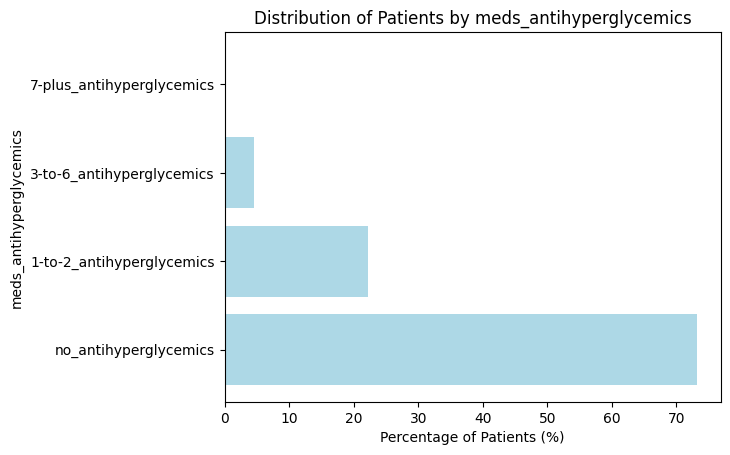

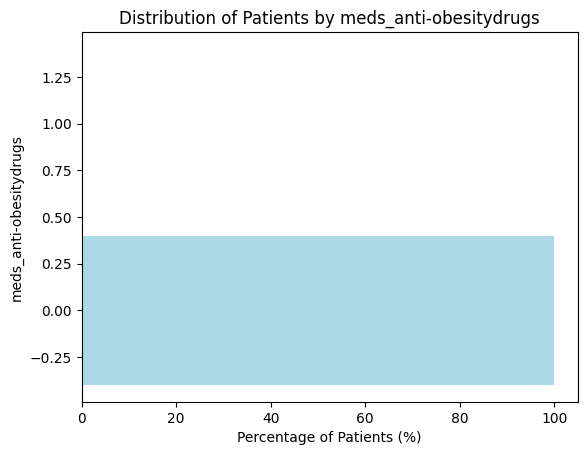

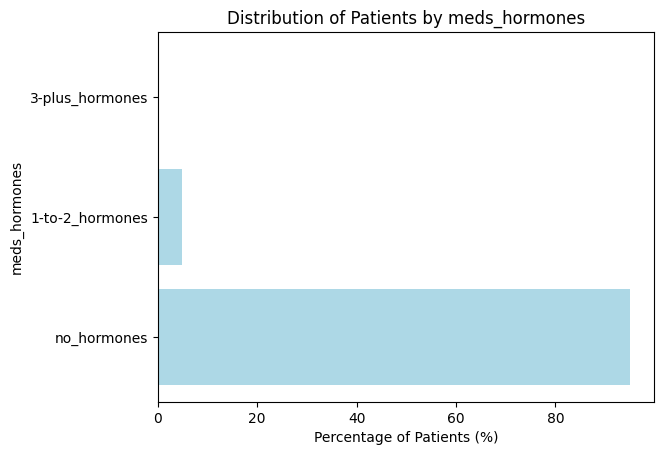

In [248]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `meds` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [249]:
#Isolating columns of interest
columns_of_interest = meds


In [250]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for meds_antihyperglycemics:
meds_antihyperglycemics
1-to-2_antihyperglycemics    18.503792
3-to-6_antihyperglycemics     4.073769
7-plus_antihyperglycemics     0.002840
no_antihyperglycemics        23.390800
dtype: float64


Percentage Admission for meds_anti-obesitydrugs:
meds_anti-obesitydrugs
0.0    45.950373
1.0     0.020828
dtype: float64


Percentage Admission for meds_hormones:
meds_hormones
1-to-2_hormones     4.472341
3-plus_hormones     0.043549
no_hormones        41.455310
dtype: float64




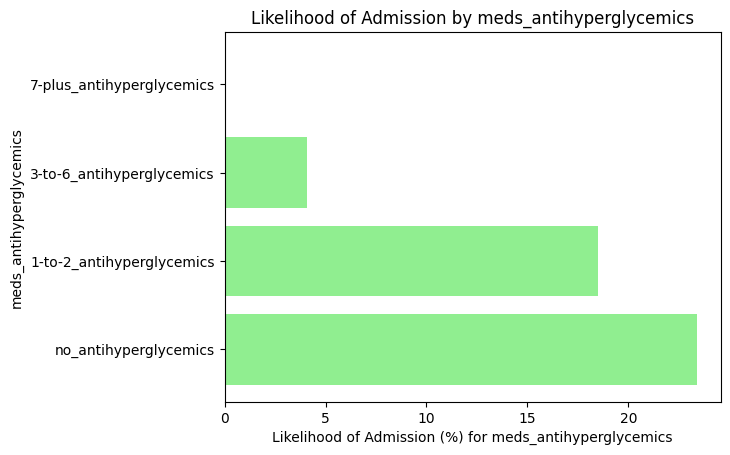

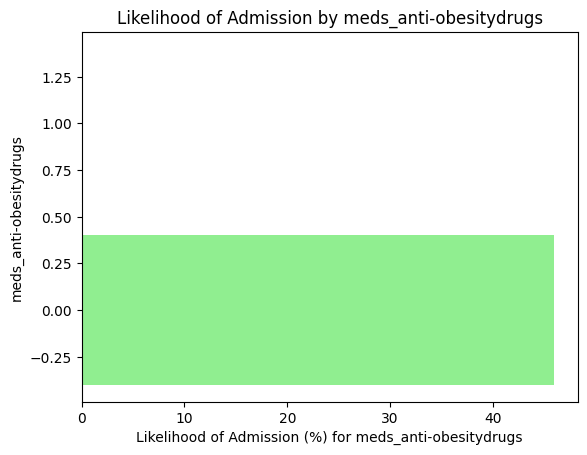

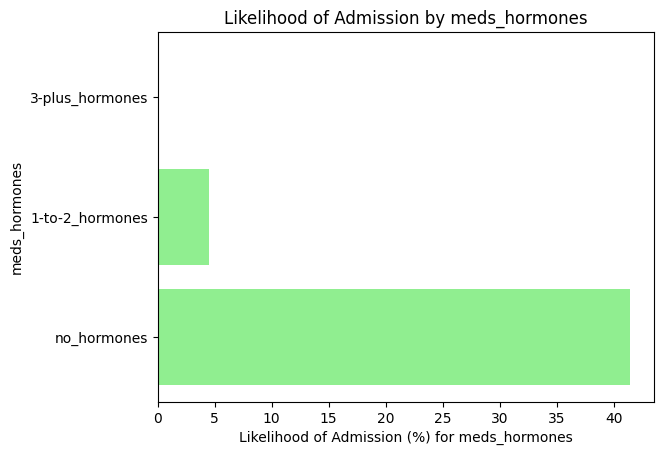

In [251]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Meds` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [252]:
#Establishing X and Y
X = health_data[meds]
Y = health_data['disposition']

In [253]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                 Variable1     ChiSquare   P_Value
0  meds_antihyperglycemics  22808.644564  0.000000
1   meds_anti-obesitydrugs      3.368000  0.066474
2            meds_hormones   4517.303325  0.000000


In [254]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

sorted_df

,Variable1,ChiSquare,P_Value
0,meds_antihyperglycemics,22808.644564,0.0
2,meds_hormones,4517.303325,0.0


---
Key takeaways: 

#### Medication Categories and Admission Rates Analysis:


#### Percentage Distribution for `meds_antihyperglycemics`:
- **no_antihyperglycemics (73.17%):** A significant portion of the population in the dataset is not prescribed antihyperglycemic medications.
- **1-to-2_antihyperglycemics (22.28%):** A substantial percentage is prescribed a moderate number (1 to 2) of antihyperglycemic medications.
- **3-to-6_antihyperglycemics (4.55%):** A smaller percentage is prescribed a higher number (3 to 6) of antihyperglycemic medications.
- **7-plus_antihyperglycemics (0.00%):** Almost negligible percentage is prescribed seven or more antihyperglycemic medications.

#### Percentage Admission for `meds_antihyperglycemics`:
- **1-to-2_antihyperglycemics (18.50%):** Among those prescribed 1 to 2 antihyperglycemic medications, a notable percentage is admitted.
- **3-to-6_antihyperglycemics (4.07%):** Among those prescribed 3 to 6 antihyperglycemic medications, a smaller percentage is admitted.
- **7-plus_antihyperglycemics (0.00%):** No admissions are reported for those prescribed seven or more antihyperglycemic medications.
- **no_antihyperglycemics (23.39%):** Among those not prescribed antihyperglycemics, a significant percentage is admitted.


#### Percentage Distribution for `meds_anti-obesitydrugs`:
- **0.0 (99.97%):** The overwhelming majority of the population is not prescribed anti-obesity drugs.
- **1.0 (0.03%):** A very small percentage is prescribed anti-obesity drugs.


#### Percentage Admission for `meds_anti-obesitydrugs`:
- **0.0 (45.95%):** Among those not prescribed anti-obesity drugs, a significant percentage is admitted.
- **1.0 (0.02%):** A very small percentage of those prescribed anti-obesity drugs is admitted.


#### Percentage Distribution for `meds_hormones`:
- **no_hormones (95.04%):** The majority of the population is not prescribed hormones.
- **1-to-2_hormones (4.91%):** A smaller percentage is prescribed a moderate number (1 to 2) of hormones.
- **3-plus_hormones (0.05%):** A very small percentage is prescribed three or more hormones.

#### Percentage Admission for `meds_hormones`:
- **1-to-2_hormones (4.47%):** Among those prescribed 1 to 2 hormones, a small percentage is admitted.
- **3-plus_hormones (0.04%):** A very small percentage of those prescribed three or more hormones is admitted.
- **no_hormones (41.45%):** Among those not prescribed hormones, a significant percentage is admitted.


#### Interpretation of Chi-Square Test: 
- For `meds_antihyperglycemics`, the high chi-square value (22847.47) and low p-value (0.00) suggest a strong association.
- For `meds_anti-obesitydrugs`, the chi-square value (3.35) is higher, and the p-value (0.07) is slightly above the significance threshold of 0.05.
- For `meds_hormones`, the high chi-square value (4514.10) and low p-value (0.00) suggest a strong association.


---
#### <a id = 'glu'></a> 1.9 Disposition vs Median Glucose Reading

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `'hist_glucose_median'`column. 

In [255]:
hist_glu = ['hist_glucose_median']

First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition?  
----

What is the distribution?
`'hist_glucose_median'`column. What are the percentages of each unique entry from the whole? What is the distribution?

In [256]:
# Define the list of columns to analyze
columns_of_interest = hist_glu

In [257]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for hist_glucose_median:
hist_glucose_median
Normal             76.987891
>200(high)         15.821712
>300(very high)     7.190396
Name: count, dtype: float64




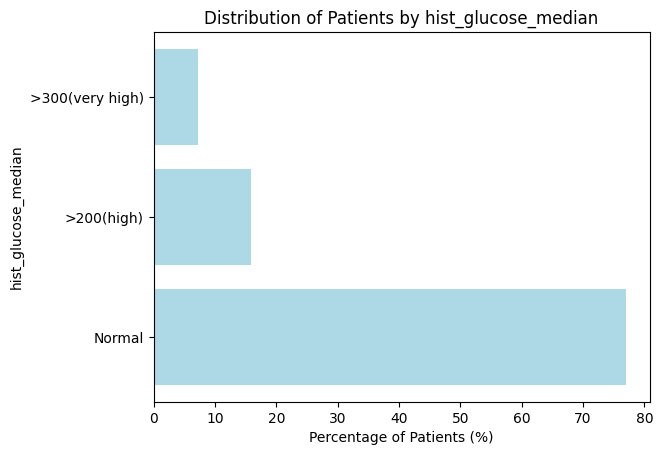

In [258]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `hist_glucose_median` column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [259]:
#Isolating columns of interest
columns_of_interest = hist_glu


In [260]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for hist_glucose_median:
hist_glucose_median
>200(high)          7.022826
>300(very high)     3.458396
Normal             35.489979
dtype: float64




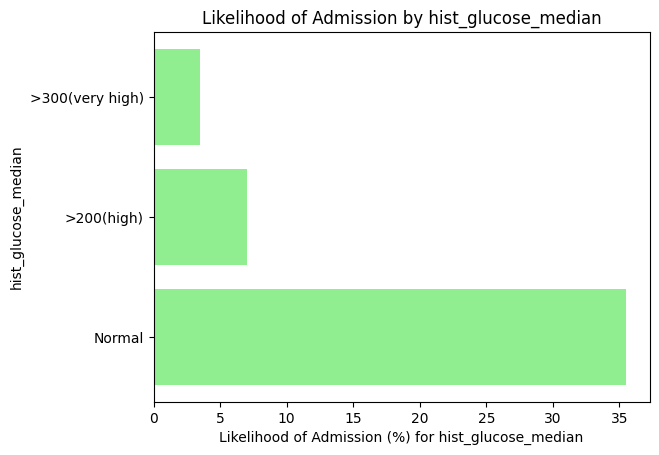

In [261]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Triage Categorical` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [262]:
#Establishing X and Y
X = health_data[hist_glu]
Y = health_data['disposition']

In [263]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


             Variable1  ChiSquare       P_Value
0  hist_glucose_median  31.232362  1.651881e-07


In [264]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

             Variable1  ChiSquare       P_Value
0  hist_glucose_median  31.232362  1.651881e-07


---
Key takeaways: 

#### Glucose Level History and Admission Rates Analysis:
#### `hist_glucose_median`:
  - **Percentage Distribution:**
    - Normal: 77.01%
    - .>200 (high): 15.81%
    - .>300 (very high): 7.17%
  - **Admission Rates:**
    - .>200 (high): 7.03%
    - .>300 (very high): 3.45%
    - Normal: 35.53%
  - **Disparities:**
    - Higher admission rate for >200 (high) glucose level (15.81%) and >300 (very high) glucose level (7.17%), and much lower admission rate for Normal glucose level (77.01%).

#### Interpretation of Chi-Square Test: 
- For `hist_glucose_median`, the chi-square value (31.41) is higher, and the p-value (1.51e-07) is much below the significance threshold of 0.05.


---
### <a id = 'conc'></a> Conclusion

In [265]:
health_data.shape

(105627, 412)

After doing some light feature engineering, the data set is now 411 columns and 105,243 rows. 

In general, it seems as though all of the different super columns are significantly related to the target variable (hospital admission) for diabetic patients. There doesn't seem to be huge apparent disparities when it comes to overall demographic data.  Let's create another CSV file that contains some feature engineering done as we move onto the next notebook.

In [266]:
health_data.to_csv('clean_health_data_pt1.csv', index=False) 

----